In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
use_monthly_aggregation = False #True, lo divide en meses, False, lo deja anual
time_key_for_plot = 'month' if use_monthly_aggregation == True else 'year'
discount_rate = 0.06

study_case = "sen_model"
inputs_path = "inputs_opp"
outputs_path = "outputs_plan_2_reserves_low_var"

In [38]:
# Step 1: Read the CSV file
file_path = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{outputs_path}\battery_operational_results_extended.csv'
data = pd.read_csv(file_path)
file_path_periods = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{inputs_path}\periods.csv'
periods_data = pd.read_csv(file_path_periods)
file_path_timeseries = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{inputs_path}\timeseries.csv'
timeseries_data = pd.read_csv(file_path_timeseries)
file_path_gen_build_costs = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{inputs_path}\gen_build_costs.csv'
gen_build_costs_data = pd.read_csv(file_path_gen_build_costs)
file_path_gen_build = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{outputs_path}\gen_build.csv'
gen_build_data = pd.read_csv(file_path_gen_build)
file_path_gen_cap = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{outputs_path}\gen_cap.csv'
gen_cap_data = pd.read_csv(file_path_gen_cap)
gen_cap_data

,GENERATION_PROJECT,PERIOD,gen_tech,gen_load_zone,gen_energy_source,GenCapacity,SuspendGen_total,GenStorageCapacity,GenCapitalRecovery,GenFixedOMCosts
0,ABANICO,2024,HYDRO,Bio Bio_3,Hidroelectrica,136.00,0,.,0.0,0.0
1,ABANICO,2026,HYDRO,Bio Bio_3,Hidroelectrica,136.00,0,.,0.0,0.0
2,ABANICO,2029,HYDRO,Bio Bio_3,Hidroelectrica,136.00,0,.,0.0,0.0
3,ABANICO,2030,HYDRO,Bio Bio_3,Hidroelectrica,136.00,0,.,0.0,0.0
4,ABANICO,2031,HYDRO,Bio Bio_3,Hidroelectrica,136.00,0,.,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12339,Zapallar,2030,TERMO,Gxnode-Zapallar-Maule,Diesel,3.11,0,.,0.0,0.0
12340,Zapallar,2031,TERMO,Gxnode-Zapallar-Maule,Diesel,3.11,0,.,0.0,0.0
12341,Zapallar,2033,TERMO,Gxnode-Zapallar-Maule,Diesel,3.11,0,.,0.0,0.0
12342,Zapallar,2040,TERMO,Gxnode-Zapallar-Maule,Diesel,3.11,0,.,0.0,0.0


In [39]:
periods_data["period_duration_years"] = periods_data["period_end"] - periods_data["period_start"]
periods_data = periods_data.rename(columns={"INVESTMENT_PERIOD": "PERIOD"})
periods_data

,PERIOD,period_start,period_end,period_duration_years
0,2024,2024,2026,2
1,2026,2026,2029,3
2,2029,2029,2030,1
3,2030,2030,2031,1
4,2031,2031,2033,2
5,2033,2033,2040,7
6,2040,2040,2050,10
7,2050,2050,2060,10


In [40]:
# Step 2: Filter by the specific project
project_name = "CAES_NuevaPozoAlmonte220_250_14h"
filtered_data = data[data['generation_project'] == project_name].copy()
filtered_cost = gen_build_costs_data[(gen_build_costs_data["gen_overnight_cost"] != 0) & (gen_build_costs_data["GENERATION_PROJECT"] == project_name)].copy()
filtered_cost = filtered_cost.rename(columns={"build_year": "PERIOD"})
filtered_gen_build = gen_build_data[gen_build_data["GENERATION_PROJECT"] == project_name].copy()
filteder_gen_cap = gen_cap_data[gen_cap_data["GENERATION_PROJECT"] == project_name][["PERIOD", "GenCapacity"]].copy()
filteder_gen_cap

,PERIOD,GenCapacity
1400,2024,0.00000
1401,2026,0.00000
1402,2029,1.86386
1403,2030,150.01300
1404,2031,150.01300
1405,2033,152.99000
1406,2040,199.98400
1407,2050,250.00000


In [41]:
df_merge_cost_build = pd.merge(filtered_gen_build, filtered_cost, on=['GENERATION_PROJECT','PERIOD'], how='inner', suffixes=('_df1', '_df2'))
# df_merge_cost_build = pd.merge(df_merge_cost_build, periods_data, on='PERIOD', how='inner', suffixes=('_df1', '_df2'))
df_merge_cost_build = pd.merge(df_merge_cost_build, filteder_gen_cap, on='PERIOD', how='inner', suffixes=('_df1', '_df2'))

df_merge_cost_build["capex"] = df_merge_cost_build["build_gen_predetermined"].astype(float)*df_merge_cost_build["gen_overnight_cost"].astype(float)
#Fixed operation and maintenance costs per MW of capacity per year
df_merge_cost_build["opex"] = df_merge_cost_build["GenCapacity"].astype(float)*df_merge_cost_build["gen_fixed_om"].astype(float)#*df_merge_cost_build["period_duration_years"]


# df_consolidated_opex_capex_period = df_merge_cost_build[["PERIOD", "capex", "opex"]].copy()
consolidated_capex_cost_period_dict = df_merge_cost_build.set_index("PERIOD")["capex"].to_dict()
consolidated_opex_cost_period_dict = df_merge_cost_build.set_index("PERIOD")["opex"].to_dict()
consolidated_opex_cost_period_dict

{2024: 0.0,
 2026: 0.0,
 2029: 20683.25442,
 2030: 1664694.2610000002,
 2031: 1664694.2610000002,
 2033: 1602570.25,
 2040: 1967842.56,
 2050: 2460000.0}

In [42]:
df_periods_expanded = periods_data.loc[periods_data.index.repeat(periods_data['period_duration_years'])].reset_index(drop=True)
df_periods_expanded['year'] = df_periods_expanded['period_start'] + df_periods_expanded.groupby('period_start').cumcount()
df_periods_expanded

,PERIOD,period_start,period_end,period_duration_years,year
0,2024,2024,2026,2,2024
1,2024,2024,2026,2,2025
2,2026,2026,2029,3,2026
3,2026,2026,2029,3,2027
4,2026,2026,2029,3,2028
5,2029,2029,2030,1,2029
6,2030,2030,2031,1,2030
7,2031,2031,2033,2,2031
8,2031,2031,2033,2,2032
9,2033,2033,2040,7,2033


In [43]:
# Step 3: Convert timepoints to datetime and aggregate by month
filtered_data['timepoint'] = pd.to_datetime(filtered_data['timepoint'], format="%Y-%m-%d-%H:%M")
filtered_data['timeseries'] = filtered_data['timepoint'].dt.strftime('%Y%m%d').astype(int)
filtered_data['month'] = filtered_data['timepoint'].dt.to_period('M')
filtered_data['year'] = filtered_data['timepoint'].dt.year

filtered_data

,generation_project,timepoint,charge_cost,discharge_earnings,timeseries,month,year
6912,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 00:00:00,0.000000,0.000000,20240123,2024-01,2024
6913,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 01:00:00,0.000000,0.000000,20240123,2024-01,2024
6914,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 02:00:00,0.000000,0.000000,20240123,2024-01,2024
6915,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 03:00:00,0.000000,0.000000,20240123,2024-01,2024
6916,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 04:00:00,0.000000,0.000000,20240123,2024-01,2024
...,...,...,...,...,...,...,...
9211,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 19:00:00,0.000000,41787.281665,20501223,2050-12,2050
9212,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 20:00:00,0.000000,0.000000,20501223,2050-12,2050
9213,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 21:00:00,26974.314137,0.000000,20501223,2050-12,2050
9214,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 22:00:00,0.000000,0.000000,20501223,2050-12,2050


In [44]:
df_expanded_periods = pd.merge(
    filtered_data,
    df_periods_expanded[['period_start', 'year']],
    left_on='year',
    right_on='period_start',
    how='inner'
)
df_expanded_periods['year'] = df_expanded_periods['year_y']
df_expanded_periods['month'] = df_expanded_periods.apply(lambda row: pd.Period(year=row['year'], month=row['month'].month, freq='M'), axis=1)
df_expanded_periods = df_expanded_periods.rename(columns={'year_x': 'PERIOD'})
df_expanded_periods = df_expanded_periods.drop(columns=['period_start', 'year_y']).sort_values(['month', 'timepoint']).reset_index(drop=True)

df_expanded_periods = pd.merge(df_expanded_periods, periods_data, on="PERIOD", how="inner")


df_expanded_periods

,generation_project,timepoint,charge_cost,discharge_earnings,timeseries,month,PERIOD,year,period_start,period_end,period_duration_years
0,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 00:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2
1,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 01:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2
2,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 02:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2
3,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 03:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2
4,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 04:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2
...,...,...,...,...,...,...,...,...,...,...,...
10363,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 19:00:00,0.000000,41787.281665,20501223,2059-12,2050,2059,2050,2060,10
10364,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 20:00:00,0.000000,0.000000,20501223,2059-12,2050,2059,2050,2060,10
10365,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 21:00:00,26974.314137,0.000000,20501223,2059-12,2050,2059,2050,2060,10
10366,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 22:00:00,0.000000,0.000000,20501223,2059-12,2050,2059,2050,2060,10


In [45]:
# Step 3.5: Add scale value of timeseries for revenue and cost scale

timeseries_data_dict = timeseries_data.set_index('TIMESERIES')['ts_scale_to_period'].to_dict()
df_expanded_periods['ts_scale_to_period'] = df_expanded_periods['timeseries'].map(timeseries_data_dict)
df_expanded_periods['ts_scale_to_period'] = df_expanded_periods['ts_scale_to_period']/df_expanded_periods['period_duration_years']

df_expanded_periods['charge_cost_scaled'] = df_expanded_periods['charge_cost'] * df_expanded_periods['ts_scale_to_period']
df_expanded_periods['discharge_earnings_scaled'] = df_expanded_periods['discharge_earnings'] * df_expanded_periods['ts_scale_to_period']
df_expanded_periods

,generation_project,timepoint,charge_cost,discharge_earnings,timeseries,month,PERIOD,year,period_start,period_end,period_duration_years,ts_scale_to_period,charge_cost_scaled,discharge_earnings_scaled
0,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 00:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2,29.92,0.00000,0.000000
1,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 01:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2,29.92,0.00000,0.000000
2,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 02:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2,29.92,0.00000,0.000000
3,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 03:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2,29.92,0.00000,0.000000
4,CAES_NuevaPozoAlmonte220_250_14h,2024-01-23 04:00:00,0.000000,0.000000,20240123,2024-01,2024,2024,2024,2026,2,29.92,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10363,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 19:00:00,0.000000,41787.281665,20501223,2059-12,2050,2059,2050,2060,10,9.00,0.00000,376085.534987
10364,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 20:00:00,0.000000,0.000000,20501223,2059-12,2050,2059,2050,2060,10,9.00,0.00000,0.000000
10365,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 21:00:00,26974.314137,0.000000,20501223,2059-12,2050,2059,2050,2060,10,9.00,242768.82723,0.000000
10366,CAES_NuevaPozoAlmonte220_250_14h,2050-12-23 22:00:00,0.000000,0.000000,20501223,2059-12,2050,2059,2050,2060,10,9.00,0.00000,0.000000


In [46]:

aggregated_data = df_expanded_periods.groupby(time_key_for_plot).agg({
    'PERIOD': 'max',
    'discharge_earnings_scaled': 'sum',
    'charge_cost_scaled': 'sum'
}).reset_index()

Se agregan luego los costos de OPEX y CAPEX para cada periodo

In [47]:
aggregated_data["capex"] = aggregated_data["year"].map(consolidated_capex_cost_period_dict).fillna(0).astype(float)
aggregated_data["opex"] = aggregated_data["PERIOD"].map(consolidated_opex_cost_period_dict).fillna(0).astype(float)

aggregated_data = aggregated_data[[time_key_for_plot, "discharge_earnings_scaled", "charge_cost_scaled", "capex", "opex"]].copy()

In [48]:
aggregated_data

,year,discharge_earnings_scaled,charge_cost_scaled,capex,opex
0,2024,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2025,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2026,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2027,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2028,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,2029,3.998681e+05,1.553762e+05,2.068312e+06,2.068325e+04
6,2030,9.372377e+08,3.437766e+08,1.643999e+08,1.664694e+06
7,2031,1.640501e+07,6.079322e+06,0.000000e+00,1.664694e+06
8,2032,1.640501e+07,6.079322e+06,0.000000e+00,1.664694e+06
9,2033,2.116369e+07,8.751249e+06,3.117911e+06,1.602570e+06


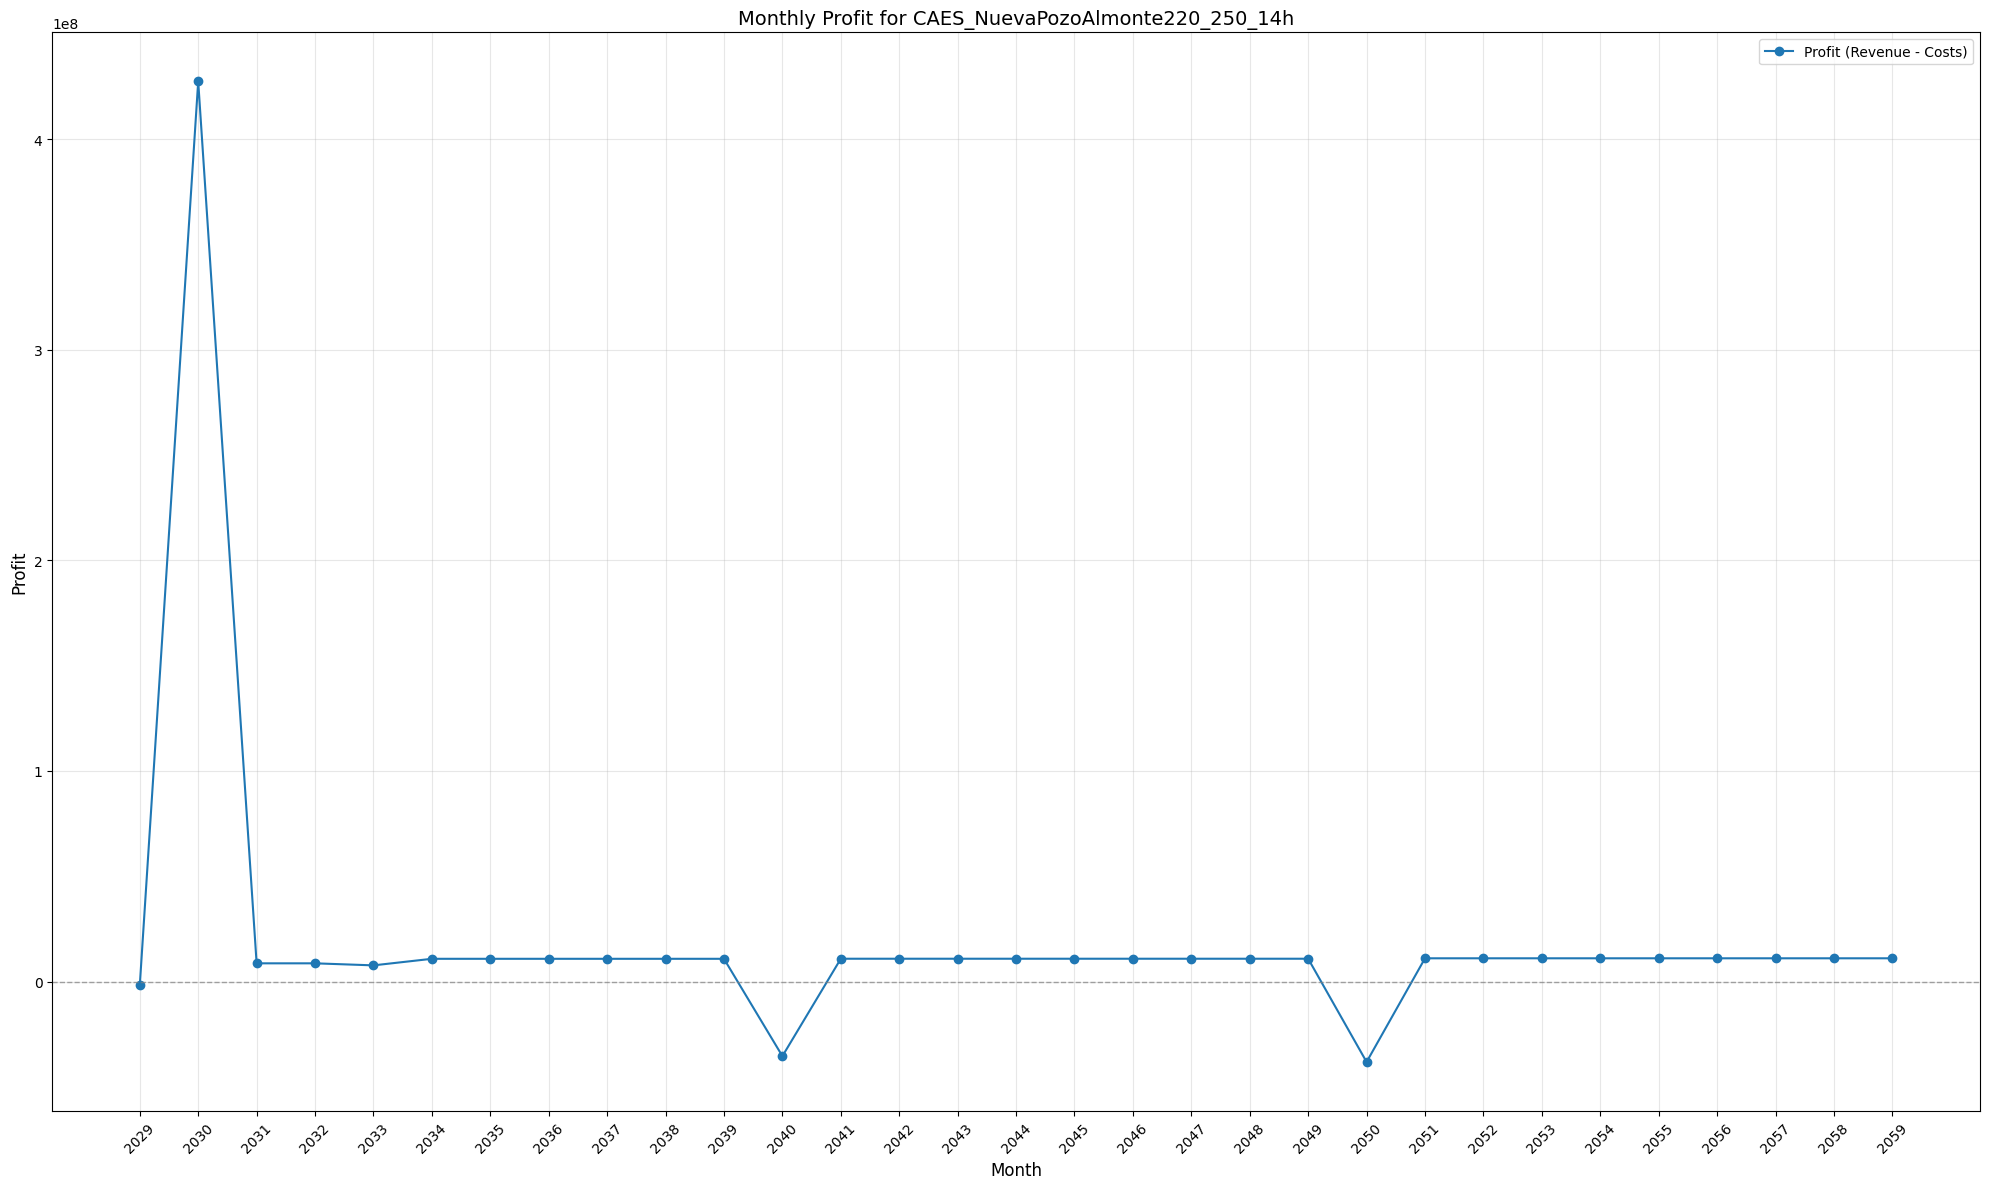

In [49]:
# Step 4: Calculate profit
aggregated_data['profit'] = aggregated_data['discharge_earnings_scaled'] - aggregated_data['charge_cost_scaled']
aggregated_data['cash_flow'] = aggregated_data['profit'] - aggregated_data["capex"] - aggregated_data["opex"]
aggregated_data = aggregated_data[aggregated_data["cash_flow"] != 0].copy()
# Step 5: Plot the results
plt.figure(figsize=(20, 12))
plt.plot(aggregated_data[time_key_for_plot].astype(str), aggregated_data['cash_flow'], marker='o', label='Profit (Revenue - Costs)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.title(f'Monthly Profit for {project_name}', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# with pd.ExcelWriter(f'evaluacion_proyecto_2.xlsx', engine='xlsxwriter') as writer:
#     aggregated_data.set_index("year").T.to_excel(writer, sheet_name='ingreso_neto_anual', index=False)

Generar excel con cash flow y VPN

In [51]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment, numbers

# Create a workbook and select the active sheet
wb = Workbook()
ws = wb.active
ws.title = "NPV Analysis"

# Step 1: Write data to the workbook
# Headers
ws["A2"] = "Income"
ws["A3"] = "Capex"
ws["A4"] = "Opex"
ws["A5"] = "Cash Flow"

# Years as headers
for idx, year in enumerate(aggregated_data['year'], start=2):
    ws.cell(row=1, column=idx, value=year)

# Write data rows
for idx, col in enumerate(['profit', 'capex', 'opex', 'cash_flow'], start=2):
    for year_idx, value in enumerate(aggregated_data[col], start=2):
        cell = ws.cell(row=idx, column=year_idx, value=value)
        cell.number_format = numbers.FORMAT_CURRENCY_USD_SIMPLE

# Step 2: Add discount rate and NPV calculation
ws["A10"] = "Discount Rate"
discount_rate_cell = ws["B10"]
discount_rate_cell.value = discount_rate  # Discount rate as a decimal
discount_rate_cell.number_format = numbers.FORMAT_PERCENTAGE_00

ws["A12"] = "NPV"
# Add Excel formula for NPV
cash_flow_range = f"{get_column_letter(3)}5:{get_column_letter(len(aggregated_data) + 1)}5"
npv_cell = ws["B12"]
npv_cell.value = f"=NPV(B10, {cash_flow_range})+B5"
npv_cell.number_format = numbers.FORMAT_CURRENCY_USD_SIMPLE  # Money format for NPV

# Step 3: Format and align cells
for cell in ["A2", "A3", "A4", "A5", "A10", "A12"]:
    ws[cell].alignment = Alignment(horizontal="left")

ws["B10"].alignment = Alignment(horizontal="right")
ws["B12"].alignment = Alignment(horizontal="right")

# Step 4: Adjust columns width
for col in ws.columns:
    max_length = 0
    col_letter = get_column_letter(col[0].column)  # Get column letter
    for cell in col:
        try:
            if cell.value:  # Check if the cell has a value
                max_length = max(max_length, len(str(cell.value)))
        except:
            pass
    adjusted_width = max_length  # Add some padding
    ws.column_dimensions[col_letter].width = adjusted_width

# Save the workbook
output_file = fr'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\{study_case}\{outputs_path}\battery_npv_analysis.xlsx'
wb.save(output_file)
print(f"Workbook saved as '{output_file}'")


Workbook saved as 'C:\Users\maty_\Desktop\Magister\Tesis\Scripts\sen_model\outputs_plan_2_reserves_low_var\battery_npv_analysis.xlsx'


Calcular VPN dentro del dataframe (template)

In [52]:
import pandas as pd
import numpy as np

# Step 3: Calculate the discount factor for each year
aggregated_data['discount_factor'] = 1 / (1 + discount_rate) ** (aggregated_data['year'] - aggregated_data['year'].min())

# Step 4: Calculate the discounted cash flow for each year
aggregated_data['discounted_cash_flow'] = aggregated_data['cash_flow'] * aggregated_data['discount_factor']

# Step 5: Calculate the total NPV
total_npv = aggregated_data['discounted_cash_flow'].sum()

# Step 6: Add NPV summary to the DataFrame
summary = pd.DataFrame({'Metric': ['Total NPV'], 'Value': [total_npv]})

summary
# Step 7: Write the data to an Excel file
# with pd.ExcelWriter('npv_analysis.xlsx') as writer:
#     merged_data.to_excel(writer, sheet_name='Detailed Cash Flows', index=False)
#     summary.to_excel(writer, sheet_name='Summary', index=False)

# print("NPV analysis saved to 'npv_analysis.xlsx'")


,Metric,Value
0,Total NPV,4.823210e+08
